# LDE Project

In [1]:
# packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import json
import pandas as pd
import seaborn as sn

In [2]:
# lockdown effect
def myrate(t, r):
    if t>=17:    #from the 17th day
        return r
    else:
        return 1

In [3]:
def mymodel(t, z, beta, mu, gamma, fD, delta_c, k, nu, r):
    S, E, I, R, H, D = z
    dD = gamma_H*H
    dS = -beta*S*I*myrate(t, r)/(1+(dD/delta_c)**k)
    dE = beta*S*I*myrate(t, r)/(1+(dD/delta_c)**k) - mu*E 
    dI = mu*E - gamma*I
    dR = (1-fD)*gamma*I + nu*H   #nu non c'era nel weitz, da H a R
    dH = fD*gamma*I - gamma_H*H - nu*H  
    return [dS, dE, dI, dR, dH, dD]

In [4]:
# two-step lockdown
def two_rate(t, r1, r2):
    if t>=17 and t<28:
        return r1
    elif t>=28 and t<85:
        return r2
    else:
        return 1

def twostep_model(t, z, beta, mu, gamma, fD, delta_c, k, nu, r1, r2):
    S, E, I, R, H, D = z
    dD = gamma_H*nu*H
    dS = -beta*S*I*two_rate(t, r1, r2)/(1+(dD/delta_c)**k)
    dE = beta*S*I*two_rate(t, r1, r2)/(1+(dD/delta_c)**k) - mu*E
    dI = mu*E - gamma*I
    dR = (1-fD)*gamma*I + gamma_H*(1-nu)*H
    dH = fD*gamma*I - gamma_H*H      
    return [dS, dE, dI, dR, dH, dD]

In [5]:
# model parameters
R_0 = 3.49
mu = 1/2      #(mean latency period)^-1
gamma = 1/6   #(mean infectious period)^-1
beta = R_0 * gamma
gamma_H = 1/10   # (mean hospital stay)^-1
fD = 0.08
k = 1
nu = 3239/6909 #ratio from H to D n(D/H)/n(H)=3239/6909 section 3.1 April
r = 0.31
r1 = 0.36
r2 = 0.26
delta_c = (50/60)*1e-6
N = 60*1e6

# initial situation in Italy
S0 = 60.352*1e6
E0 = 1695
I0 = 308.8
R0 = 311.1
H0 = 127.4
D0 = 0
N0 = E0+I0+H0+R0+S0
z0 = np.array([S0, E0, I0, R0, H0, D0])/N0

## one/two-step lockdown

In [6]:
t = np.arange(85)

sol = solve_ivp(mymodel, [0,85], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, r))
sol2 = solve_ivp(twostep_model, [0,85], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, r1,r2))

S, E, I, R, H, D = sol.sol(t)
S2, E2, I2, R2, H2, D2 = sol2.sol(t)

x = [S, E, I, R, H, D]
x2 = [S2, E2, I2, R2, H2, D2]

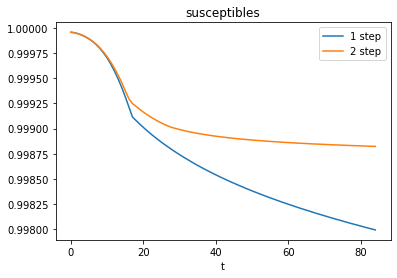

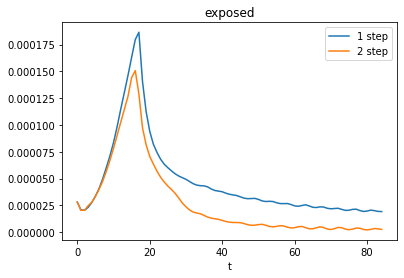

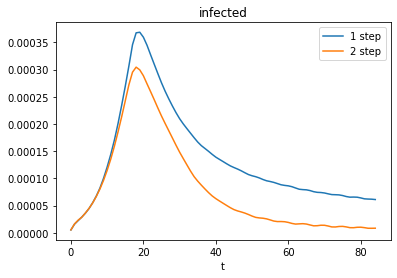

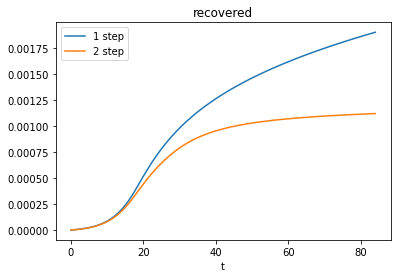

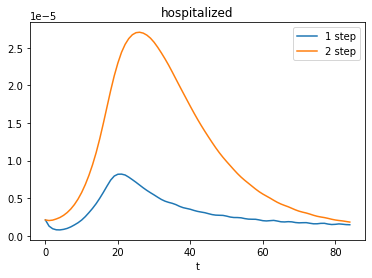

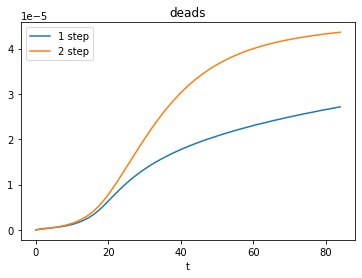

In [15]:
names = ['susceptibles', 'exposed', 'infected', 'recovered', 'hospitalized', 'deads']

for i,(col,col2) in enumerate(zip(x, x2)):
    plt.figure(i)
    plt.plot(t, col.T, label = '1 step')
    plt.plot(t, col2.T, label = '2 step')
    plt.xlabel('t')
    plt.legend()
    plt.title(names[i])

    

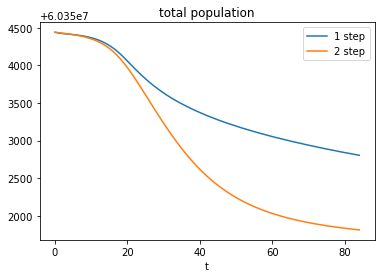

In [8]:
# total population plot
N = N0*(S+E+I+R+H)
N2 = N0*(S2+E2+I2+R2+H2)

plt.plot(t,N,label='1 step')
plt.plot(t,N2,label='2 step')
plt.title('total population')
plt.xlabel('t')
plt.legend()
plt.show()

## Italian situation

In [16]:
f = open('Data/covid_data_dpc.json')
raw_data = json.load(f)

In [17]:
# from dictionary to dataframe
df = pd.DataFrame.from_dict(raw_data)
df.head()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,...,tamponi,casi_testati,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido
0,2020-02-24T18:00:00,ITA,101,26,127,94,221,0,221,1,...,4324,NaN,None,NaN,None,None,NaN,NaN,NaN,NaN
1,2020-02-25T18:00:00,ITA,114,35,150,162,311,90,93,1,...,8623,NaN,None,NaN,None,None,NaN,NaN,NaN,NaN
2,2020-02-26T18:00:00,ITA,128,36,164,221,385,74,78,3,...,9587,NaN,None,NaN,None,None,NaN,NaN,NaN,NaN
3,2020-02-27T18:00:00,ITA,248,56,304,284,588,203,250,45,...,12014,NaN,None,NaN,None,None,NaN,NaN,NaN,NaN
4,2020-02-28T18:00:00,ITA,345,64,409,412,821,233,238,46,...,15695,NaN,None,NaN,None,None,NaN,NaN,NaN,NaN


In [ ]:
# columns names
#df.columns

In [18]:
# dataframe with reduced dates
# from 24/02 to 18/05 
df_red = df.loc[0:84]

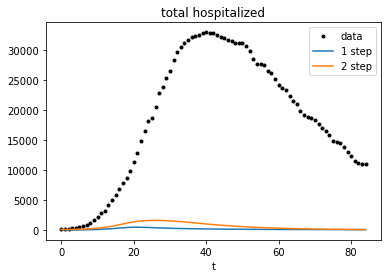

In [21]:
# plot total hospitalized
plt.plot(t, df_red['totale_ospedalizzati'], 'k.', label = 'data')
plt.plot(t, H*N, label='1 step')
plt.plot(t, H2*N2, label='2 step')
plt.title('total hospitalized')
plt.xlabel('t')
plt.legend()
plt.show()

## Parameter space: rate & $\delta_c$

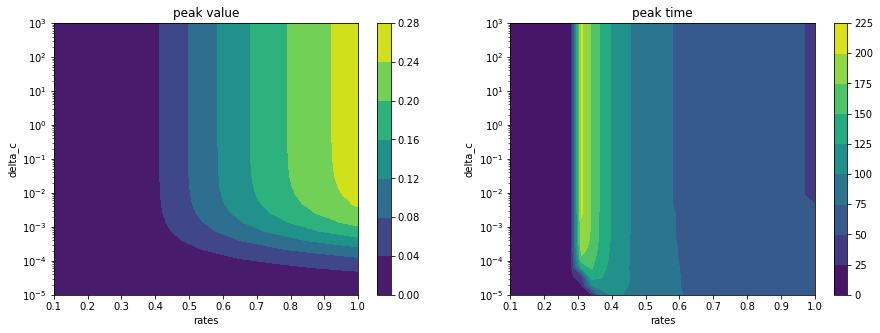

In [22]:
# change: rates & delta_c
# look at: peak values & peak times

t_max = 250
t = np.arange(t_max)

delta_c = np.logspace(-5, 3, 31) #101 PUNTI PER PLOT PIù FINE
rates = np.linspace(0.1, 1, 31)

peak_times = np.zeros((len(delta_c), len(rates)))
peak_values = np.zeros((len(delta_c), len(rates)))

for i, delta in enumerate(delta_c):
    for j, r in enumerate(rates):
        sol = solve_ivp(mymodel, [0, t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, k, nu, r))
        S, E, I, R, H, D = sol.sol(t)
        peak_time = np.argmax(I)
        peak_value = np.max(I)
        peak_times[i, j] = peak_time
        peak_values[i, j] = peak_value
        
# plots
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

X, Y = np.meshgrid(rates, delta_c)   

f1 = ax1.contourf(X, Y, peak_values)
ax1.set_title('peak value')
ax1.set_xlabel('rates')
ax1.set_ylabel('delta_c')
ax1.set_yscale('log')

f2 = ax2.contourf(X, Y, peak_times)
ax2.set_title('peak time')
ax2.set_xlabel('rates')
ax2.set_ylabel('delta_c')
ax2.set_yscale('log')

fig.colorbar(f1, ax=ax1)
fig.colorbar(f2, ax=ax2)
plt.show()

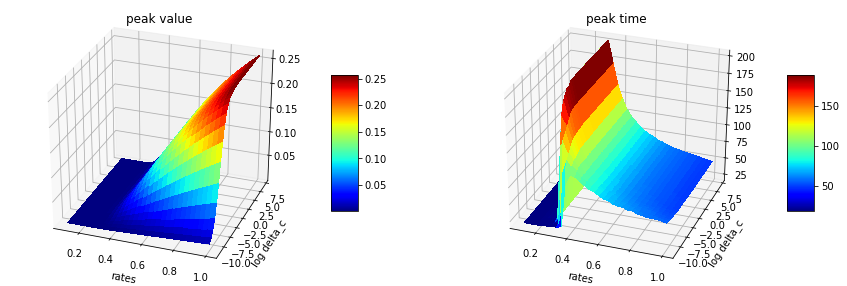

In [58]:
# 3D plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),subplot_kw={"projection": "3d"})

surf1 = ax1.plot_surface(X, np.log(Y), peak_values, cmap='jet',linewidth=0, antialiased=False)
ax1.view_init(30, 290)  #230
ax1.set_title('peak value')
ax1.set_xlabel('rates')
ax1.set_ylabel('log delta_c')

surf2 = ax2.plot_surface(X, np.log(Y), peak_times, cmap='jet',linewidth=0, antialiased=False)
ax2.view_init(30, 290)
ax2.set_title('peak time')
ax2.set_xlabel('rates')
ax2.set_ylabel('log delta_c')

fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
plt.show()

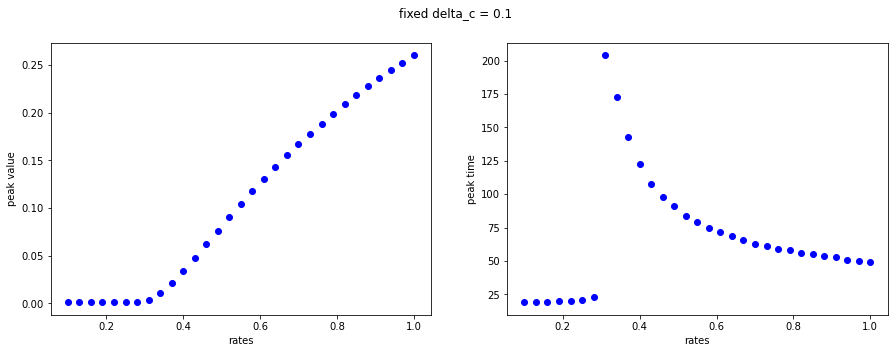

In [41]:
# fixed delta_c
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(rates, peak_values[15,:], 'bo')
ax1.set_xlabel('rates')
ax1.set_ylabel('peak value')

ax2.plot(rates, peak_times[15,:], 'bo')
ax2.set_xlabel('rates')
ax2.set_ylabel('peak time')

fig.suptitle('fixed delta_c = 0.1')
plt.show()

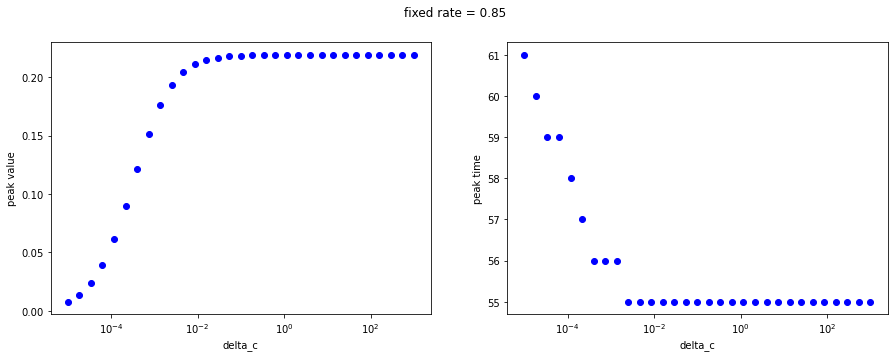

In [42]:
# fixed rate
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(delta_c, peak_values[:,25], 'bo')
ax1.set_xscale('log')
ax1.set_xlabel('delta_c')
ax1.set_ylabel('peak value')

ax2.plot(delta_c, peak_times[:,25], 'bo')
ax2.set_xscale('log')
ax2.set_xlabel('delta_c')
ax2.set_ylabel('peak time')

fig.suptitle('fixed rate = 0.85')
plt.show()

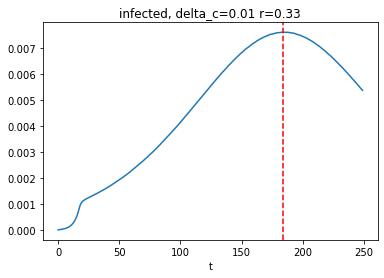

In [74]:
# example of infected dynamics

sol = solve_ivp(mymodel, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, 1e-2, k, nu, 0.33))
t = np.arange(t_max)
S, E, I, R, H, D = sol.sol(t)
peak_time = np.argmax(I)
peak_time

# plot
plt.plot(t,I)
plt.axvline(peak_time, color='r', linestyle='--',label='peak')
plt.title('infected, delta_c=0.01 r=0.33')
plt.xlabel('t')
plt.show()

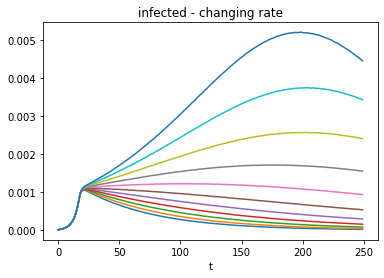

In [89]:
# infected dynamics
# changing rates

delta_c = 1e-1
rates = np.linspace(0.25, 0.32, 11)

Is = np.zeros(shape=(11, t_max))
for i,r in enumerate(rates):
    sol = solve_ivp(mymodel, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, r))
    S, E, I, R, H, D = sol.sol(t)
    Is[i,:]=I
    
plt.plot(t,Is.T)
plt.xlabel('t')
plt.title('infected - changing rate')
plt.show()

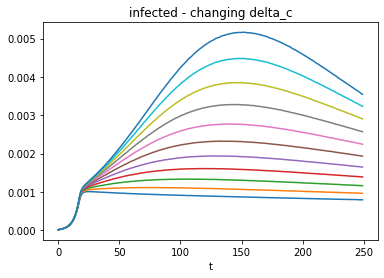

In [92]:
# infected dynamics
# changing delta_c

delta_c = np.logspace(-5, -4, 11)
rates = 0.35

Is = np.zeros(shape=(11, t_max))
for i,delta in enumerate(delta_c):
    sol = solve_ivp(mymodel, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, k, nu, rates))
    S, E, I, R, H, D = sol.sol(t)
    Is[i,:]=I
    
plt.plot(t,Is.T)
plt.xlabel('t')
plt.title('infected - changing delta_c')
plt.show()

## Parameter $k = 4$

In [96]:
k1 = 4

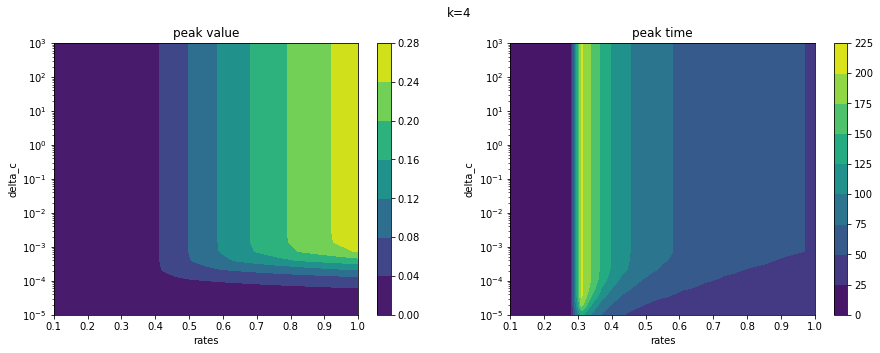

In [105]:
# change: rates & delta_c
# look at: peak values & peak times

t_max = 250
t = np.arange(t_max)

delta_c = np.logspace(-5, 3, 31)
rates = np.linspace(0.1, 1, 31)

peak_times = np.zeros((len(delta_c), len(rates)))
peak_values = np.zeros((len(delta_c), len(rates)))

for i, delta in enumerate(delta_c):
    for j, r in enumerate(rates):
        sol = solve_ivp(mymodel, [0, t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, k1, nu, r))
        S, E, I, R, H, D = sol.sol(t)
        peak_time = np.argmax(I)
        peak_value = np.max(I)
        peak_times[i, j] = peak_time
        peak_values[i, j] = peak_value

# plots
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

X, Y = np.meshgrid(rates, delta_c)   

f1 = ax1.contourf(X, Y, peak_values)
ax1.set_title('peak value')
ax1.set_xlabel('rates')
ax1.set_ylabel('delta_c')
ax1.set_yscale('log')

f2 = ax2.contourf(X, Y, peak_times)
ax2.set_title('peak time')
ax2.set_xlabel('rates')
ax2.set_ylabel('delta_c')
ax2.set_yscale('log')

fig.colorbar(f1, ax=ax1)
fig.colorbar(f2, ax=ax2)
fig.suptitle('k=4')
plt.show()

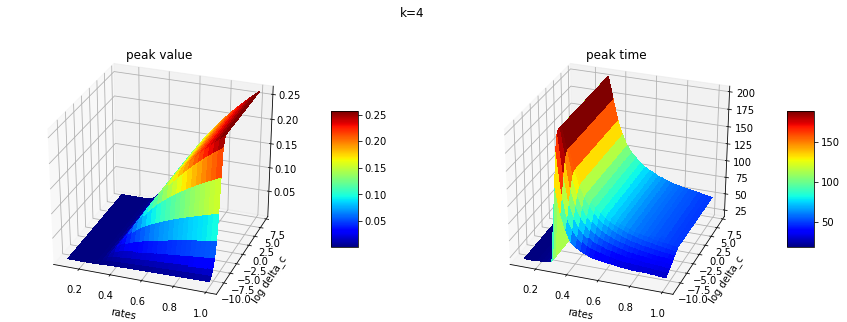

In [104]:
# 3D plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),subplot_kw={"projection": "3d"})

surf1 = ax1.plot_surface(X, np.log(Y), peak_values, cmap='jet',linewidth=0, antialiased=False)
ax1.view_init(30, 290)  #230
ax1.set_title('peak value')
ax1.set_xlabel('rates')
ax1.set_ylabel('log delta_c')

surf2 = ax2.plot_surface(X, np.log(Y), peak_times, cmap='jet',linewidth=0, antialiased=False)
ax2.view_init(30, 290)
ax2.set_title('peak time')
ax2.set_xlabel('rates')
ax2.set_ylabel('log delta_c')

fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
fig.suptitle('k=4')
plt.show()

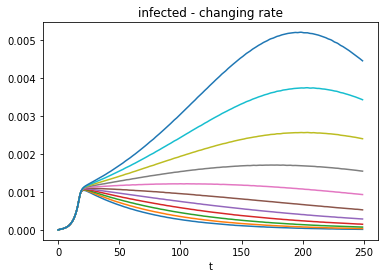

In [99]:
# infected dynamics
# changing rates

delta_c = 1e-1
rates = np.linspace(0.25, 0.32, 11)

Is = np.zeros(shape=(11, t_max))
for i,r in enumerate(rates):
    sol = solve_ivp(mymodel, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k1, nu, r))
    S, E, I, R, H, D = sol.sol(t)
    Is[i,:]=I
    
plt.plot(t,Is.T)
plt.xlabel('t')
plt.title('infected - changing rate')
plt.show()

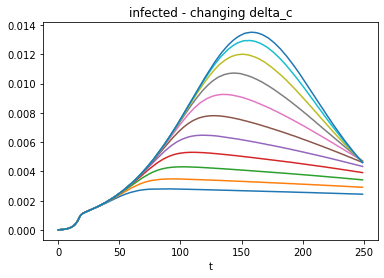

In [100]:
# infected dynamics
# changing delta_c

delta_c = np.logspace(-5, -4, 11)
rates = 0.35

Is = np.zeros(shape=(11, t_max))
for i,delta in enumerate(delta_c):
    sol = solve_ivp(mymodel, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, k1, nu, rates))
    S, E, I, R, H, D = sol.sol(t)
    Is[i,:]=I
    
plt.plot(t,Is.T)
plt.xlabel('t')
plt.title('infected - changing delta_c')
plt.show()